# Project: 30-Day Readmission Risk (Diabetes Inpatient Encounters)

## Objective
  Analyze patterns associated with 30-day hospital readmissions and build a baseline machine learning model that generates a readmission risk score. Use that risk score to create an operational “high-risk queue” by flagging the top 10% highest-risk encounters for follow-up.

### Why this matters
  Reducing readmissions improves patient outcomes and lowers avoidable costs. A practical workflow is:

1. Identify groups with higher readmission rates,

2. Build a model to estimate readmission risk, and

3. Use a dashboard to monitor trends and prioritize interventions.

# Dataset
UCI “Diabetes 130-US hospitals (1999–2008)” inpatient encounter-level dataset (101,766 encounters).

**Target variable:** `readmit_30 = 1` if `readmitted == "<30"`, else `0` (positive rate ≈ 11.16%).

## Project Outputs (Artifacts)
**This notebook produces:**

`outputs/dashboard_data.csv` — cleaned, dashboard-ready dataset (includes binned features)

`outputs/scored_dashboard_data_top10.csv` — includes pred_prob (risk score) and high_risk_top10 flag

`models/pipeline.joblib` — trained baseline model (Logistic Regression pipeline)

`outputs/metrics_summary.txt` — summary of model evaluation results

# High-level Approach

Data cleaning and feature preparation (`"?"` → `NaN`, drop ID/high-missing columns)

Exploratory analysis (readmission rates by age, length of stay, medication burden, demographics)

Baseline ML model training + evaluation (ROC-AUC, PR-AUC)

Operational rule: flag top 10% highest predicted risks and evaluate on the test set

# **Next Step**
Build a Streamlit dashboard using the scored dataset to visualize trends and display the high-risk queue.

# Setup (Google Drive + Project Folders)
In this section, we connect Google Colab to Google Drive so we can read and write project files. We also define a consistent folder structure to keep the project organized:

**data/**: raw input files (downloaded dataset)

**outputs/**: cleaned datasets and scored outputs used for dashboards

**models/**: saved machine learning model artifacts

## Goal

Ensure all file paths are correct and confirm the dataset files are available before starting analysis.

In [42]:
# =========================
# CONNECT TO GOOGLE DRIVE
# =========================
# This lets Colab read/write files directly in your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

# =========================
# SET PROJECT FOLDER PATHS
# =========================
# Update this only if your folder name or location differs.

import os
PROJECT_DIR = "/content/drive/MyDrive/readmission_project"
DATA_DIR = os.path.join(PROJECT_DIR, "data")
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
OUT_DIR   = os.path.join(PROJECT_DIR, "outputs")

# Create folders if they don't exist (safe to run multiple times)
for p in [DATA_DIR, MODEL_DIR, OUT_DIR]:
    os.makedirs(p, exist_ok=True)

# =========================
# VERIFY FILES ARE PRESENT
# =========================

print("Data:", os.listdir(DATA_DIR))
print("Models:", os.listdir(MODEL_DIR))
print("Outputs:", os.listdir(OUT_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data: ['diabetic_data.csv', 'IDS_mapping.csv']
Models: []
Outputs: ['dashboard_data.csv', 'scored_dashboard_data_top10.csv', 'metrics_summary.txt']


# Load the Dataset

In this section, we load the main dataset (`diabetic_data.csv`) into a pandas DataFrame and verify that it was loaded correctly by checking:


*   the number of rows and columns
*   a preview of the first few records



## Goal
Confirm the dataset is accessible and correctly loaded before we begin cleaning, analysis, or modeling.

In [43]:
# =========================
# LOAD DATA FILES
# =========================
# diabetic_data.csv = main dataset with patient encounter records
# IDS_mapping.csv   = mapping for admission_type_id -> description

import pandas as pd

df = pd.read_csv(os.path.join(DATA_DIR, "diabetic_data.csv"))
ids = pd.read_csv(os.path.join(DATA_DIR, "IDS_mapping.csv"))

print(f"Main dataset loaded: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Mapping file loaded: {ids.shape[0]:,} rows x {ids.shape[1]} columns")

# Preview a few rows
display(df.head(3))
display(ids.head(10))


Main dataset loaded: 101,766 rows x 50 columns
Mapping file loaded: 67 rows x 2 columns


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO


,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped
8,NaN,NaN
9,discharge_disposition_id,description


# Understand the Target and Missing Values

Before cleaning or modeling, we first inspect two important things:

1. Target column (`readmitted`)

    The dataset labels readmission status as:
    

    * `NO` (not readmitted)

    * `> 30` (readmitted after 30 days)

    * `30` (readmitted within 30 days)

    We will later convert this into a binary target for modeling.

  2. Missing values

      This dataset uses the symbol `"?"` to represent missing or unknown values. We identify which columns contain the most missing values so we can decide how to handle them (drop, impute, or transform).

## Goal
 Understand what we’re predicting and ensure missing data is handled consistently before analysis and modeling.



In [44]:
# =========================
# UNDERSTAND THE TARGET
# =========================
# We will eventually predict whether a patient is readmitted within 30 days.
# The dataset stores this in the column: readmitted
# Values typically include: "NO", ">30", "<30"

print("Unique values in readmitted:")
print(df["readmitted"].unique())

print("\nReadmitted counts:")
display(df["readmitted"].value_counts())



Unique values in readmitted:
['NO' '>30' '<30']

Readmitted counts:


,count
readmitted,
NO,54864
>30,35545
<30,11357


In [45]:
# =========================
# CHECK MISSING VALUES
# =========================
# In this dataset, missing/unknown values are often written as "?"
# We want to see which columns have the most "?" values.

missing_q = (df == "?").sum().sort_values(ascending=False)

print("Top 10 columns with the most '?' values:")
display(missing_q.head(10))



Top 10 columns with the most '?' values:


,0
weight,98569
medical_specialty,49949
payer_code,40256
race,2273
diag_3,1423
diag_2,358
diag_1,21
admission_type_id,0
patient_nbr,0
encounter_id,0


In [46]:
# =========================
# CLEAN MISSING VALUES
# =========================
# Python tools understand NaN as missing.
# They do NOT automatically treat "?" as missing.
# So we replace "?" with NaN.

import numpy as np

df2 = df.copy()
df2 = df2.replace("?", np.nan)

print("Quick check (should be mostly zeros now):")
missing_q2 = (df2 == "?").sum().sort_values(ascending=False)
display(missing_q2.head(10))



Quick check (should be mostly zeros now):


,0
encounter_id,0
patient_nbr,0
race,0
gender,0
age,0
weight,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0


# Create the Modeling Dataset (Target `y` and Features `X`)

In this section, we convert the raw dataset into a clean format that can be used for analysis and machine learning.

## What we do:


*   Create the target (`y`)

    * We define a binary label where:

    * `y = 1` if `readmitted == "<30"` (readmitted within 30 days)

    * `y = 0` otherwise (`NO` or `>30`)


*   Create the feature table (`X`)

    `X` contains all input columns used for prediction. We build `X` by removing the target column (`readmitted`) from the dataset.

* Remove non-informative identifier columns

    We drop `encounter_id` and `patient_nbr` because they are IDs and do not represent meaningful patient/clinical features.

* Drop columns with extremely high missingness

    To keep the project simple and avoid excessive imputation, we remove:

    * `weight`

    * `medical_specialty`

    * `payer_code`

## Result:
By the end of this section, we have:

*   `y` = clean binary target
*   `X` = cleaned feature table ready for exploratory analysis and modeling

In [47]:
# =========================
# CREATE THE TARGET y
# =========================
# We'll define a binary target:
# y = 1 if readmitted is "<30"
# y = 0 if readmitted is "NO" or ">30"

y = (df2["readmitted"] == "<30").astype(int)

print("Percent readmitted in <30 days:", round(y.mean() * 100, 2), "%")
print("Target counts (0 = not <30, 1 = <30):")
display(y.value_counts())


Percent readmitted in <30 days: 11.16 %
Target counts (0 = not <30, 1 = <30):


,count
readmitted,
0,90409
1,11357


In [48]:
# =========================
# CREATE FEATURES X
# =========================
# X contains all the input columns we will use for prediction.
# We remove the target column ("readmitted") from the dataset.

X = df2.drop(columns=["readmitted"])

print("X shape:", X.shape)
display(X.head(3))


X shape: (101766, 49)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,No
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,No,Up,No,No,No,No,No,Ch,Yes
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,No,Yes


In [49]:
# =========================
# DROP ID COLUMNS
# =========================
# These columns are identifiers (like IDs), not true predictors.
# Keeping them can cause a model to learn weird patterns.

X = X.drop(columns=["encounter_id", "patient_nbr"])

print("X shape after dropping IDs:", X.shape)


X shape after dropping IDs: (101766, 47)


In [50]:
# =========================
# DROP VERY HIGH-MISSING COLUMNS
# =========================
# These columns have too many missing values for a simple first version.
# We'll drop them to keep this easier and cleaner.

drop_cols = ["weight", "medical_specialty", "payer_code"]
X = X.drop(columns=drop_cols)

print("Dropped columns:", drop_cols)
print("X shape now:", X.shape)


Dropped columns: ['weight', 'medical_specialty', 'payer_code']
X shape now: (101766, 44)


# Exploratory Analysis (Dashboard-Style Insights)

In this section, we begin exploratory analysis by combining the cleaned features (`X`) with the target (`readmit_30`) to measure readmission rates across different patient groups.

##Why this section exists:

Before building a model or dashboard, it’s important to understand the data and identify patterns that are easy to interpret and communicate.

###What we do:

*   Create an `analysis_df` dataset by temporarily adding `readmit_30` back onto the cleaned features.
*   Calculate and visualize readmission rates (with counts for context) across key segments such as:

    * **Age buckets**

    * **Time in hospital** (and binned versions for smoother trends)

    * **Number of medications** (and binned versions to reduce noise)

    * **Demographics** (gender and race)

In [51]:
# =========================
# COMBINE X AND y FOR ANALYSIS
# =========================
# We temporarily add the target (y) back into a copy of X
# so we can group and calculate readmission rates.

analysis_df = X.copy()
analysis_df["readmit_30"] = y

print("analysis_df shape:", analysis_df.shape)
analysis_df[["age", "time_in_hospital", "num_medications", "readmit_30"]].head()


analysis_df shape: (101766, 45)


,age,time_in_hospital,num_medications,readmit_30
0,[0-10),1,1,0
1,[10-20),3,18,0
2,[20-30),2,13,0
3,[30-40),2,16,0
4,[40-50),1,8,0


In [52]:
# =========================
# READMISSION RATE BY AGE
# =========================
# This calculates the percent of encounters readmitted in <30 days
# for each age bucket.

age_rates = analysis_df.groupby("age")["readmit_30"].mean().sort_index()

print("Readmission rate by age bucket:")
display((age_rates * 100).round(2))


Readmission rate by age bucket:


,readmit_30
age,
[0-10),1.86
[10-20),5.79
[20-30),14.24
[30-40),11.23
[40-50),10.60
[50-60),9.67
[60-70),11.13
[70-80),11.77
[80-90),12.08


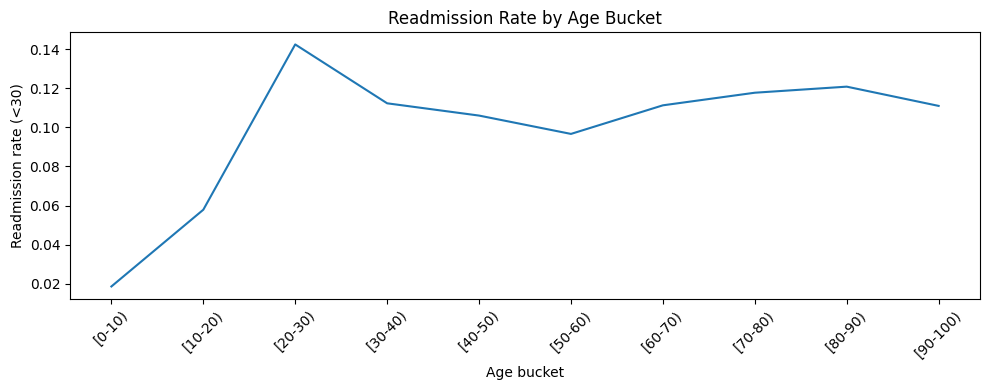

In [53]:
# =========================
# PLOT: AGE vs READMISSION RATE
# =========================
# Simple line plot to visualize the pattern.

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(age_rates.index, age_rates.values)
plt.xticks(rotation=45)
plt.xlabel("Age bucket")
plt.ylabel("Readmission rate (<30)")
plt.title("Readmission Rate by Age Bucket")
plt.tight_layout()
plt.show()


In [54]:
# =========================
# READMISSION RATE BY TIME IN HOSPITAL
# =========================
# time_in_hospital is numeric (days). We'll compute the rate per day value.

time_rates = analysis_df.groupby("time_in_hospital")["readmit_30"].mean().sort_index()

print("Readmission rate by time in hospital (days):")
display((time_rates * 100).round(2))


Readmission rate by time in hospital (days):


,readmit_30
time_in_hospital,
1,8.18
2,9.94
3,10.67
4,11.81
5,12.03
6,12.59
7,12.83
8,14.23
9,13.72


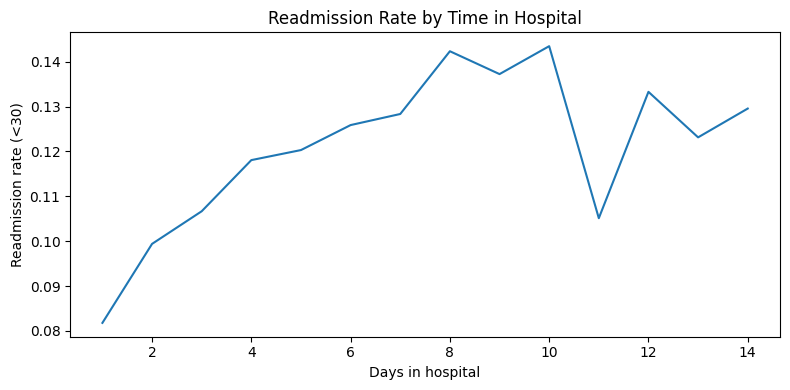

In [55]:
# =========================
# PLOT: TIME IN HOSPITAL vs READMISSION RATE
# =========================

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(time_rates.index, time_rates.values)
plt.xlabel("Days in hospital")
plt.ylabel("Readmission rate (<30)")
plt.title("Readmission Rate by Time in Hospital")
plt.tight_layout()
plt.show()


In [56]:
# =========================
# AGE: SHOW RATE + COUNT
# =========================
# We want to see how many rows exist in each age bucket.
# If a bucket has a very small count, the rate can look like a spike and
# misleading.

age_summary = analysis_df.groupby("age").agg(
    readmit_rate=("readmit_30", "mean"),
    count=("readmit_30", "size")
).sort_index()

age_summary["readmit_rate_pct"] = (age_summary["readmit_rate"] * 100).round(2)

display(age_summary[["readmit_rate_pct", "count"]])


,readmit_rate_pct,count
age,,
[0-10),1.86,161
[10-20),5.79,691
[20-30),14.24,1657
[30-40),11.23,3775
[40-50),10.60,9685
[50-60),9.67,17256
[60-70),11.13,22483
[70-80),11.77,26068
[80-90),12.08,17197


In [57]:
# =========================
# TIME IN HOSPITAL: SHOW RATE + COUNT
# =========================
# Same idea: check how many rows exist for each number of hospital days.

time_summary = analysis_df.groupby("time_in_hospital").agg(
    readmit_rate=("readmit_30", "mean"),
    count=("readmit_30", "size")
).sort_index()

time_summary["readmit_rate_pct"] = (time_summary["readmit_rate"] * 100).round(2)

display(time_summary[["readmit_rate_pct", "count"]])


,readmit_rate_pct,count
time_in_hospital,,
1,8.18,14208
2,9.94,17224
3,10.67,17756
4,11.81,13924
5,12.03,9966
6,12.59,7539
7,12.83,5859
8,14.23,4391
9,13.72,3002


In [58]:
# =========================
# READMISSION RATE BY NUM_MEDICATIONS
# =========================

med_summary = analysis_df.groupby("num_medications").agg(
    readmit_rate=("readmit_30", "mean"),
    count=("readmit_30", "size")
).sort_index()

med_summary["readmit_rate_pct"] = (med_summary["readmit_rate"] * 100).round(2)

display(med_summary[["readmit_rate_pct", "count"]])


,readmit_rate_pct,count
num_medications,,
1,4.20,262
2,8.30,470
3,7.22,900
4,8.05,1417
5,7.44,2017
...,...,...
72,100.00,3
74,0.00,1
75,0.00,2


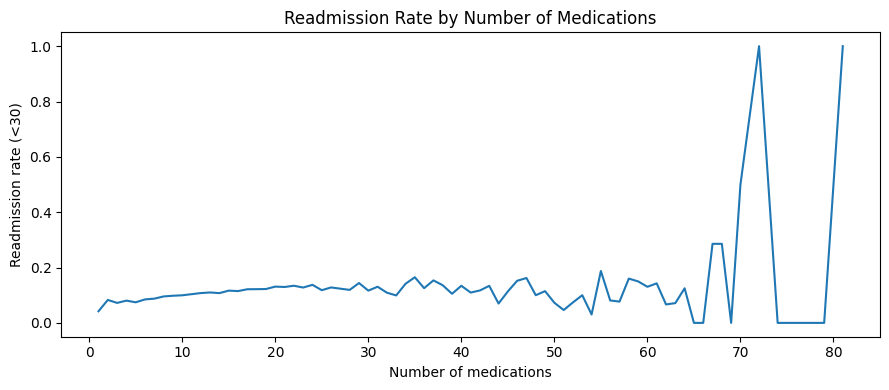

In [59]:
# =========================
# PLOT: NUM_MEDICATIONS vs READMISSION RATE
# =========================

import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
plt.plot(med_summary.index, med_summary["readmit_rate"])
plt.xlabel("Number of medications")
plt.ylabel("Readmission rate (<30)")
plt.title("Readmission Rate by Number of Medications")
plt.tight_layout()
plt.show()


In [60]:
# =========================
# BIN NUM_MEDICATIONS INTO RANGES
# =========================
# This makes the chart smoother and more dashboard-friendly.
# Example bins: 0–5, 6–10, 11–15, 16–20, 21–30, 31–40, 41+

import pandas as pd

analysis_df2 = analysis_df.copy()

bins = [0, 5, 10, 15, 20, 30, 40, 1000]
labels = ["0–5", "6–10", "11–15", "16–20", "21–30", "31–40", "41+"]

analysis_df2["num_meds_bin"] = pd.cut(
    analysis_df2["num_medications"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

med_bin_summary = analysis_df2.groupby("num_meds_bin").agg(
    readmit_rate=("readmit_30", "mean"),
    count=("readmit_30", "size")
)

med_bin_summary["readmit_rate_pct"] = (med_bin_summary["readmit_rate"] * 100).round(2)

print("Readmission rate by medication bin:")
display(med_bin_summary[["readmit_rate_pct", "count"]])


Readmission rate by medication bin:


/tmp/ipython-input-2977297491.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med_bin_summary = analysis_df2.groupby("num_meds_bin").agg(


,readmit_rate_pct,count
num_meds_bin,,
0–5,7.48,5066
6–10,9.45,20795
11–15,10.91,29384
16–20,12.17,22641
21–30,12.87,18643
31–40,12.82,3876
41+,11.32,1361


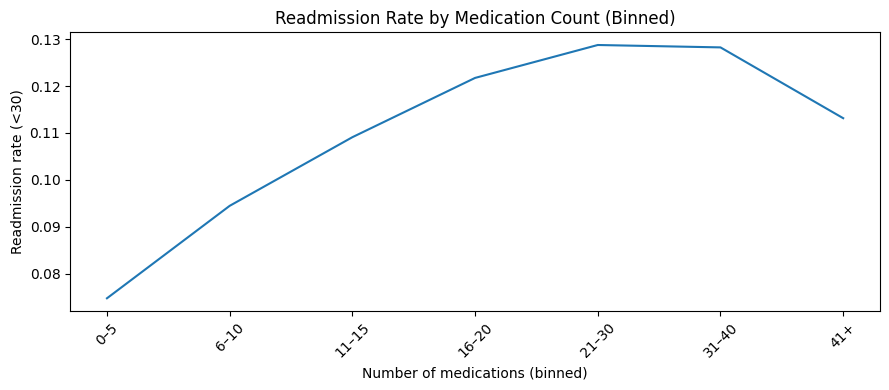

In [61]:
# =========================
# PLOT: BINNED NUM_MEDICATIONS vs READMISSION RATE
# =========================

import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
plt.plot(med_bin_summary.index.astype(str), med_bin_summary["readmit_rate"])
plt.xticks(rotation=45)
plt.xlabel("Number of medications (binned)")
plt.ylabel("Readmission rate (<30)")
plt.title("Readmission Rate by Medication Count (Binned)")
plt.tight_layout()
plt.show()


In [62]:
# =========================
# BIN TIME_IN_HOSPITAL INTO RANGES
# =========================
# Example bins: 1–2, 3–4, 5–6, 7–8, 9–10, 11–14

bins_time = [0, 2, 4, 6, 8, 10, 14]
labels_time = ["1–2", "3–4", "5–6", "7–8", "9–10", "11–14"]

analysis_df2["time_bin"] = pd.cut(
    analysis_df2["time_in_hospital"],
    bins=bins_time,
    labels=labels_time,
    include_lowest=True
)

time_bin_summary = analysis_df2.groupby("time_bin").agg(
    readmit_rate=("readmit_30", "mean"),
    count=("readmit_30", "size")
)

time_bin_summary["readmit_rate_pct"] = (time_bin_summary["readmit_rate"] * 100).round(2)

print("Readmission rate by time-in-hospital bin:")
display(time_bin_summary[["readmit_rate_pct", "count"]])


Readmission rate by time-in-hospital bin:


/tmp/ipython-input-893822877.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_bin_summary = analysis_df2.groupby("time_bin").agg(


,readmit_rate_pct,count
time_bin,,
1–2,9.14,31432
3–4,11.17,31680
5–6,12.27,17505
7–8,13.43,10250
9–10,14.00,5344
11–14,12.10,5555


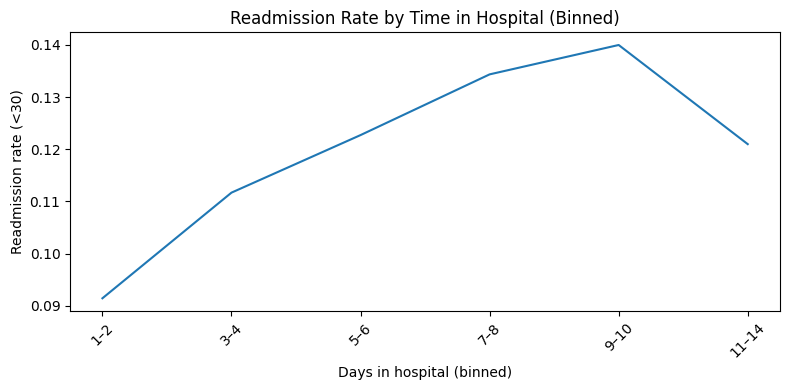

In [63]:
# =========================
# PLOT: BINNED TIME_IN_HOSPITAL vs READMISSION RATE
# =========================

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(time_bin_summary.index.astype(str), time_bin_summary["readmit_rate"])
plt.xticks(rotation=45)
plt.xlabel("Days in hospital (binned)")
plt.ylabel("Readmission rate (<30)")
plt.title("Readmission Rate by Time in Hospital (Binned)")
plt.tight_layout()
plt.show()


In [64]:
# =========================
# READMISSION RATE BY GENDER
# =========================

gender_summary = analysis_df2.groupby("gender").agg(
    readmit_rate=("readmit_30", "mean"),
    count=("readmit_30", "size")
).sort_values("readmit_rate", ascending=False)

gender_summary["readmit_rate_pct"] = (gender_summary["readmit_rate"] * 100).round(2)

display(gender_summary[["readmit_rate_pct", "count"]])


,readmit_rate_pct,count
gender,,
Female,11.25,54708
Male,11.06,47055
Unknown/Invalid,0.00,3


In [65]:
# =========================
# READMISSION RATE BY RACE
# =========================
# Note: race has some missing values (now NaN). We'll keep them as "Missing".

analysis_df2["race_filled"] = analysis_df2["race"].fillna("Missing")

race_summary = analysis_df2.groupby("race_filled").agg(
    readmit_rate=("readmit_30", "mean"),
    count=("readmit_30", "size")
).sort_values("readmit_rate", ascending=False)

race_summary["readmit_rate_pct"] = (race_summary["readmit_rate"] * 100).round(2)

display(race_summary[["readmit_rate_pct", "count"]])


,readmit_rate_pct,count
race_filled,,
Caucasian,11.29,76099
AfricanAmerican,11.22,19210
Hispanic,10.41,2037
Asian,10.14,641
Other,9.63,1506
Missing,8.27,2273


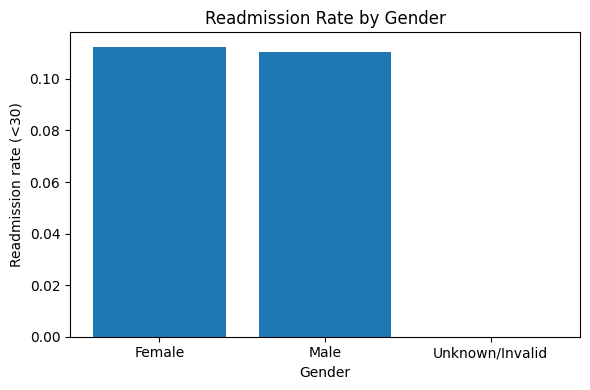

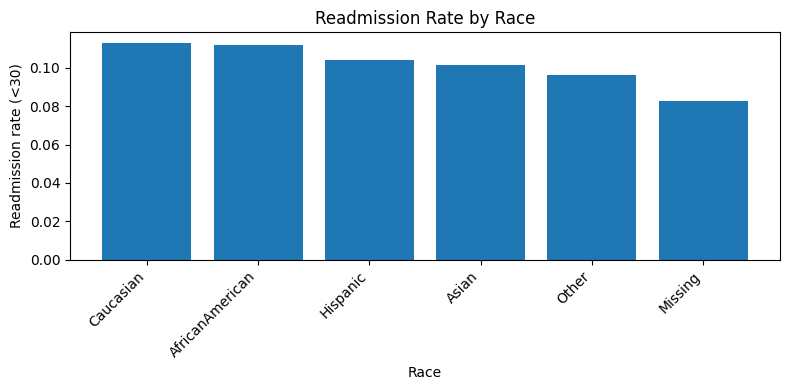

In [66]:
# =========================
# PLOTS: GENDER + RACE
# =========================

import matplotlib.pyplot as plt

# Gender bar chart
plt.figure(figsize=(6,4))
plt.bar(gender_summary.index.astype(str), gender_summary["readmit_rate"])
plt.xlabel("Gender")
plt.ylabel("Readmission rate (<30)")
plt.title("Readmission Rate by Gender")
plt.tight_layout()
plt.show()

# Race bar chart (top categories)
plt.figure(figsize=(8,4))
plt.bar(race_summary.index.astype(str), race_summary["readmit_rate"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Race")
plt.ylabel("Readmission rate (<30)")
plt.title("Readmission Rate by Race")
plt.tight_layout()
plt.show()


# Export a Dashboard-Ready Dataset

In this section, we save a cleaned dataset that can be reused for dashboards and future modeling without repeating the preprocessing steps.

## What we export:

We create `dashboard_data.csv`, which includes:



*   the target label (`readmit_30`)
*   key demographic and utilization features used in the EDA (e.g., age,  gender, race, time in hospital, number of medications)

*   binned variables (e.g., `time_bin`, `num_meds_bin`) to support cleaner dashboard visuals

## Why this matters:

Exporting a dashboard-ready file makes the workflow more realistic:

*   the notebook handles cleaning + feature prep once

*   the dashboard (Streamlit/Tableau) can load a single clean file and focus on visualization


### Output created:

`outputs/dashboard_data.csv`







In [67]:
# =========================
# EXPORT DASHBOARD-READY DATASET
# =========================
# This saves a clean, analysis-friendly CSV to outputs/
# so we can reuse it later in Streamlit/Tableau without redoing steps.

import os

dashboard_cols = [
    "race", "gender", "age",
    "time_in_hospital", "num_medications",
    "admission_type_id", "discharge_disposition_id", "admission_source_id",
    "num_meds_bin", "time_bin",
    "readmit_30"
]

dashboard_cols = [c for c in dashboard_cols if c in analysis_df2.columns]
dashboard_df = analysis_df2[dashboard_cols].copy()

out_path = os.path.join(OUT_DIR, "dashboard_data.csv")
dashboard_df.to_csv(out_path, index=False)

print("Saved:", out_path)
print("Shape:", dashboard_df.shape)
dashboard_df.head()

Saved: /content/drive/MyDrive/readmission_project/outputs/dashboard_data.csv
Shape: (101766, 11)


,race,gender,age,time_in_hospital,num_medications,admission_type_id,discharge_disposition_id,admission_source_id,num_meds_bin,time_bin,readmit_30
0,Caucasian,Female,[0-10),1,1,6,25,1,0–5,1–2,0
1,Caucasian,Female,[10-20),3,18,1,1,7,16–20,3–4,0
2,AfricanAmerican,Female,[20-30),2,13,1,1,7,11–15,1–2,0
3,Caucasian,Male,[30-40),2,16,1,1,7,16–20,1–2,0
4,Caucasian,Male,[40-50),1,8,1,1,7,6–10,1–2,0


In [68]:
# =========================
# DATA READINESS CHECK
# =========================
# We check:
# 1) which columns still have missing values
# 2) data types (numeric vs text)
# 3) how many unique values in each column

print("Missing values per column:")
display(dashboard_df.isna().sum().sort_values(ascending=False))

print("\nColumn data types:")
display(dashboard_df.dtypes)

print("\nUnique value counts (top-level view):")
display(dashboard_df.nunique().sort_values(ascending=False))

# =========================
# CLEAN TINY CATEGORIES
# =========================
# "Unknown/Invalid" gender has only 3 rows, so we can label it as Missing/Other.

dashboard_df["gender"] = dashboard_df["gender"].replace({"Unknown/Invalid": "Other/Unknown"})

# Replace missing race with "Missing"
dashboard_df["race"] = dashboard_df["race"].fillna("Missing")

dashboard_df["gender"].value_counts()



Missing values per column:


,0
race,2273
gender,0
age,0
time_in_hospital,0
num_medications,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
num_meds_bin,0
time_bin,0



Column data types:


,0
race,object
gender,object
age,object
time_in_hospital,int64
num_medications,int64
admission_type_id,int64
discharge_disposition_id,int64
admission_source_id,int64
num_meds_bin,category
time_bin,category



Unique value counts (top-level view):


,0
num_medications,75
discharge_disposition_id,26
admission_source_id,17
time_in_hospital,14
age,10
admission_type_id,8
num_meds_bin,7
time_bin,6
race,5
gender,3


,count
gender,
Female,54708
Male,47055
Other/Unknown,3


# Baseline Machine Learning Model (Logistic Regression)

In this section we train a simple baseline model that predicts the probability of 30-day readmission (`readmit_30`) using the cleaned, dashboard-ready dataset.

## What we do

*   Load `outputs/dashboard_data.csv`

*   Split the data into training and test sets (stratified to preserve class balance)

*   Build a preprocessing and modeling pipeline that:

    *   imputes missing values

    *   one-hot encodes categorical features

    *   scales numeric features

    *   trains a Logistic Regression model (with class balancing)

* Evaluate the model using:

    * ROC-AUC (ranking quality)

    * PR-AUC (useful for imbalanced classification)

## Why this matters

A baseline model provides a starting point to:

* generate a risk score (pred_prob) for each encounter

* measure whether the model adds value beyond simple heuristics

* support a dashboard use case (risk monitoring + prioritization)

### Outputs created

A trained model pipeline saved as: `models/pipeline.joblib`

## Goal / Result

By the end of this section, we have a trained model and a baseline performance benchmark to improve on later if needed.


In [69]:
# =========================
# LOAD DASHBOARD DATASET (FROM DRIVE)
# =========================
# We load the dataset and confirm it looks correct.

import os
import pandas as pd

dashboard_path = os.path.join(OUT_DIR, "dashboard_data.csv")
df_model = pd.read_csv(dashboard_path)

print("Loaded from:", dashboard_path)
print("Shape:", df_model.shape)
display(df_model.head(5))

Loaded from: /content/drive/MyDrive/readmission_project/outputs/dashboard_data.csv
Shape: (101766, 11)


,race,gender,age,time_in_hospital,num_medications,admission_type_id,discharge_disposition_id,admission_source_id,num_meds_bin,time_bin,readmit_30
0,Caucasian,Female,[0-10),1,1,6,25,1,0–5,1–2,0
1,Caucasian,Female,[10-20),3,18,1,1,7,16–20,3–4,0
2,AfricanAmerican,Female,[20-30),2,13,1,1,7,11–15,1–2,0
3,Caucasian,Male,[30-40),2,16,1,1,7,16–20,1–2,0
4,Caucasian,Male,[40-50),1,8,1,1,7,6–10,1–2,0


In [70]:
# =========================
# CHECK TARGET + BASIC INFO
# =========================

print("Columns:")
print(df_model.columns.tolist())

print("\nTarget distribution (readmit_30):")
display(df_model["readmit_30"].value_counts())

print("\nTarget percent positive:")
print(round(df_model["readmit_30"].mean() * 100, 2), "%")


Columns:
['race', 'gender', 'age', 'time_in_hospital', 'num_medications', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'num_meds_bin', 'time_bin', 'readmit_30']

Target distribution (readmit_30):


,count
readmit_30,
0,90409
1,11357



Target percent positive:
11.16 %


In [71]:
# =========================
# CREATE FEATURES (X) AND TARGET (y)
# =========================
# y = the thing we want to predict
# X = the inputs we use to predict y

y = df_model["readmit_30"]
X = df_model.drop(columns=["readmit_30"])

print("X shape:", X.shape)
print("y shape:", y.shape)
display(X.head(3))


X shape: (101766, 10)
y shape: (101766,)


,race,gender,age,time_in_hospital,num_medications,admission_type_id,discharge_disposition_id,admission_source_id,num_meds_bin,time_bin
0,Caucasian,Female,[0-10),1,1,6,25,1,0–5,1–2
1,Caucasian,Female,[10-20),3,18,1,1,7,16–20,3–4
2,AfricanAmerican,Female,[20-30),2,13,1,1,7,11–15,1–2


In [72]:
# =========================
# DEFINE NUMERIC VS CATEGORICAL COLUMNS
# =========================

numeric_cols = ["time_in_hospital", "num_medications"]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Make sure categorical columns are treated like categories (strings)
for c in categorical_cols:
    X[c] = X[c].astype(str)


Numeric columns: ['time_in_hospital', 'num_medications']
Categorical columns: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'num_meds_bin', 'time_bin']


In [73]:
# =========================
# TRAIN/TEST SPLIT
# =========================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (81412, 10)
Test size: (20354, 10)


In [74]:
# =========================
# BUILD + TRAIN BASELINE MODEL (LOGISTIC REGRESSION)
# =========================

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

clf.fit(X_train, y_train)

print("Model trained.")


Model trained.


In [75]:
# =========================
# EVALUATE MODEL
# =========================

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

proba = clf.predict_proba(X_test)[:, 1]

print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
print("PR-AUC:", round(average_precision_score(y_test, proba), 4))

threshold = 0.30
pred = (proba >= threshold).astype(int)

print("\nClassification report (threshold = 0.30):")
print(classification_report(y_test, pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, pred))


ROC-AUC: 0.6125
PR-AUC: 0.1729

Classification report (threshold = 0.30):
              precision    recall  f1-score   support

           0       0.99      0.03      0.05     18083
           1       0.11      1.00      0.20      2271

    accuracy                           0.14     20354
   macro avg       0.55      0.51      0.13     20354
weighted avg       0.89      0.14      0.07     20354

Confusion matrix:
[[  484 17599]
 [    7  2264]]


In [76]:
# =========================
# THRESHOLD TUNING
# =========================
# We test different thresholds and see how precision/recall changes.

from sklearn.metrics import precision_score, recall_score

thresholds = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70]

rows = []
for t in thresholds:
    pred_t = (proba >= t).astype(int)
    prec = precision_score(y_test, pred_t, zero_division=0)
    rec  = recall_score(y_test, pred_t, zero_division=0)
    pos_rate = pred_t.mean()  # percent predicted positive
    rows.append([t, round(prec, 4), round(rec, 4), round(pos_rate, 4)])

threshold_table = pd.DataFrame(rows, columns=["threshold", "precision", "recall", "predicted_positive_rate"])
display(threshold_table)


,threshold,precision,recall,predicted_positive_rate
0,0.1,0.1133,1.0000,0.9844
1,0.2,0.1135,1.0000,0.9828
2,0.3,0.1140,0.9969,0.9759
3,0.4,0.1190,0.9238,0.8660
4,0.5,0.1502,0.5429,0.4034
5,0.6,0.2034,0.1792,0.0983
6,0.7,0.3111,0.0678,0.0243


# Operational Risk Queue (Top 10% Highest Risk)

##Objective
Convert model probabilities into an actionable workflow by flagging a fixed-size “high-risk” group. Instead of using a fixed probability threshold, we label the top 10% highest predicted risk scores as high risk.

### What we do

* Generate predicted probabilities (`pred_prob`) from the trained model

* Compute a cutoff so that only the top 10% of encounters are flagged

* Create a binary flag:

    * `high_risk_top10` = 1 if the encounter is in the top 10% risk

    * `high_risk_top10` = 0 otherwise

* Evaluate this rule on the test set (confusion matrix + precision/recall)

* Save a scored dataset for dashboards and downstream analysis

### Why this matters

In real operations, teams often have limited capacity for follow-ups. A “top 10%” rule creates a manageable work queue while still prioritizing the highest-risk cases.

### Outputs created

`outputs/scored_dashboard_data_top10.csv `(includes `pred_prob` and `high_risk_top10`)

## Goal

By the end of this section, the model is no longer just a metric — it produces an interpretable, practical high-risk list that can be displayed directly in a dashboard.

In [77]:
# =========================
# FLAG TOP 10% HIGHEST RISK
# =========================
# We mark only the top 10% of predicted risk scores as "high risk".
# This creates a manageable work queue for follow-up.

import numpy as np

# proba comes from your test set earlier. For full dataset we use full_proba.
full_proba = clf.predict_proba(X)[:, 1]

cutoff = np.quantile(full_proba, 0.90)  # top 10%
high_risk_top10 = (full_proba >= cutoff).astype(int)

print("Top 10% cutoff probability:", round(float(cutoff), 4))
print("Percent flagged high risk:", round(high_risk_top10.mean() * 100, 2), "%")


Top 10% cutoff probability: 0.599
Percent flagged high risk: 10.01 %


In [78]:
# =========================
# SAVE SCORED DATASET (WITH HIGH-RISK FLAG)
# =========================

import os
import pandas as pd

scored_df = df_model.copy()
scored_df["pred_prob"] = full_proba
scored_df["high_risk_top10"] = high_risk_top10

scored_path = os.path.join(OUT_DIR, "scored_dashboard_data_top10.csv")
scored_df.to_csv(scored_path, index=False)

print("Saved:", scored_path)
print("Shape:", scored_df.shape)

# Quick peek at top risk rows
display(scored_df.sort_values("pred_prob", ascending=False).head(10))


Saved: /content/drive/MyDrive/readmission_project/outputs/scored_dashboard_data_top10.csv
Shape: (101766, 13)


,race,gender,age,time_in_hospital,num_medications,admission_type_id,discharge_disposition_id,admission_source_id,num_meds_bin,time_bin,readmit_30,pred_prob,high_risk_top10
67655,Caucasian,Male,[60-70),7,20,2,15,7,16–20,7–8,0,0.898510,1
72427,Caucasian,Male,[60-70),6,23,2,15,7,21–30,5–6,0,0.897525,1
44098,Caucasian,Female,[70-80),8,23,1,15,7,21–30,7–8,0,0.896218,1
81272,Caucasian,Male,[60-70),10,25,3,15,1,21–30,9–10,0,0.888555,1
60588,AfricanAmerican,Male,[70-80),8,12,2,15,1,11–15,7–8,0,0.887548,1
37013,Caucasian,Female,[70-80),5,17,2,15,7,16–20,5–6,0,0.887294,1
57697,Caucasian,Male,[60-70),10,37,1,15,1,31–40,9–10,0,0.887105,1
54555,Caucasian,Female,[70-80),8,24,1,15,1,21–30,7–8,1,0.884234,1
61936,AfricanAmerican,Female,[70-80),7,16,2,15,1,16–20,7–8,1,0.883367,1
57533,Caucasian,Male,[80-90),9,33,2,15,1,31–40,9–10,1,0.883217,1


In [79]:
# =========================
# EVALUATE TOP 10% RULE ON TEST SET
# =========================

from sklearn.metrics import confusion_matrix, classification_report

# cutoff computed from full dataset; apply same cutoff to test set probabilities
proba_test = clf.predict_proba(X_test)[:, 1]
pred_top10_test = (proba_test >= cutoff).astype(int)

print("Test set predicted positive rate:", round(pred_top10_test.mean() * 100, 2), "%")
print("Confusion matrix (Top 10% rule on test):")
print(confusion_matrix(y_test, pred_top10_test))

print("\nClassification report (Top 10% rule on test):")
print(classification_report(y_test, pred_top10_test))


Test set predicted positive rate: 10.1 %
Confusion matrix (Top 10% rule on test):
[[16446  1637]
 [ 1853   418]]

Classification report (Top 10% rule on test):
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     18083
           1       0.20      0.18      0.19      2271

    accuracy                           0.83     20354
   macro avg       0.55      0.55      0.55     20354
weighted avg       0.82      0.83      0.82     20354



In [80]:
# =========================
# SAVE METRICS SUMMARY (TEXT FILE)
# =========================

import os

summary_text = f"""
Baseline Model: Logistic Regression
Dataset: dashboard_data.csv (11 columns)
Positive rate (readmit_30=1): {df_model["readmit_30"].mean()*100:.2f}%

Overall (test):
ROC-AUC: 0.6125
PR-AUC: 0.1729

Top 10% High-Risk Rule (test):
Predicted high-risk rate: 10.1%
Confusion matrix:
TN=16446, FP=1637
FN=1853, TP=418

Readmission class metrics (test):
Precision=0.20
Recall=0.18
F1=0.19
"""

out_metrics_path = os.path.join(OUT_DIR, "metrics_summary.txt")
with open(out_metrics_path, "w") as f:
    f.write(summary_text.strip())

print("Saved:", out_metrics_path)


Saved: /content/drive/MyDrive/readmission_project/outputs/metrics_summary.txt


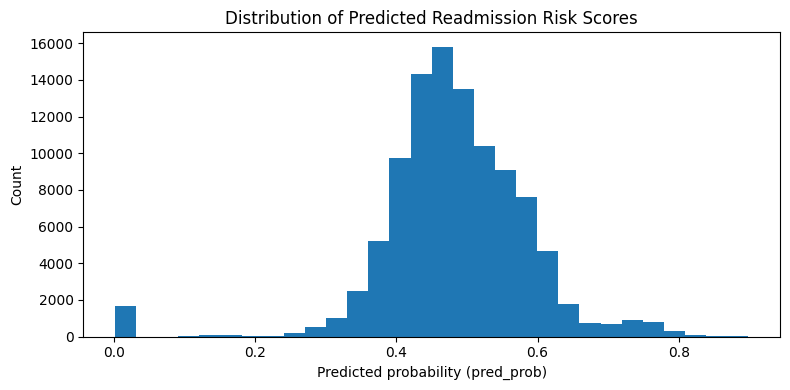

Readmission rate by risk decile (10 = highest risk):


,risk_decile,readmit_rate_pct,count
0,1,5.00,10177
1,2,7.81,10205
2,3,8.07,10151
3,4,9.44,10176
4,5,10.06,10174
5,6,11.31,10177
6,7,11.87,10176
7,8,13.56,10193
8,9,14.79,10165
9,10,19.69,10172


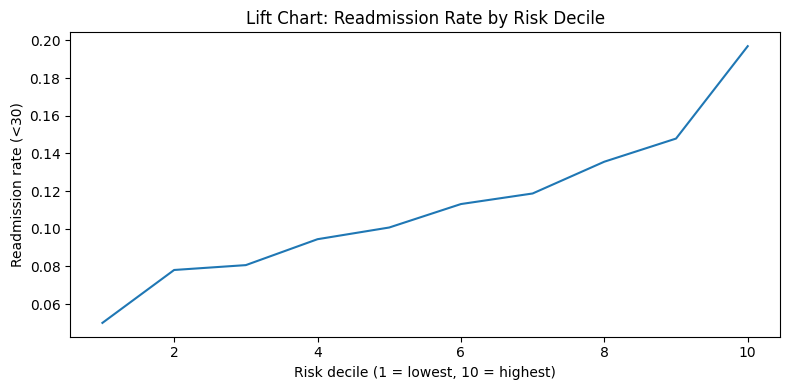

In [81]:
# =========================
# RISK DISTRIBUTION + LIFT BY DECILE
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

scored_path = os.path.join(OUT_DIR, "scored_dashboard_data_top10.csv")
scored_df = pd.read_csv(scored_path)

# A) Distribution of predicted probabilities
plt.figure(figsize=(8,4))
plt.hist(scored_df["pred_prob"], bins=30)
plt.xlabel("Predicted probability (pred_prob)")
plt.ylabel("Count")
plt.title("Distribution of Predicted Readmission Risk Scores")
plt.tight_layout()
plt.show()

# B) Lift table by risk decile (10 buckets)
scored_df["risk_decile"] = pd.qcut(scored_df["pred_prob"], 10, labels=False) + 1  # 1=lowest, 10=highest

decile_summary = scored_df.groupby("risk_decile").agg(
    readmit_rate=("readmit_30", "mean"),
    count=("readmit_30", "size")
).reset_index()

decile_summary["readmit_rate_pct"] = (decile_summary["readmit_rate"]*100).round(2)

print("Readmission rate by risk decile (10 = highest risk):")
display(decile_summary[["risk_decile","readmit_rate_pct","count"]])

plt.figure(figsize=(8,4))
plt.plot(decile_summary["risk_decile"], decile_summary["readmit_rate"])
plt.xlabel("Risk decile (1 = lowest, 10 = highest)")
plt.ylabel("Readmission rate (<30)")
plt.title("Lift Chart: Readmission Rate by Risk Decile")
plt.tight_layout()
plt.show()


In [84]:
# =========================
# SAVE MODEL TO GOOGLE DRIVE
# =========================
import os, joblib

model_path = os.path.join(MODEL_DIR, "pipeline.joblib")
joblib.dump(clf, model_path)

print("Saved model to:", model_path)
print("Files now:", os.listdir(MODEL_DIR))


Saved model to: /content/drive/MyDrive/readmission_project/models/pipeline.joblib
Files now: ['pipeline.joblib']
